## Bayesian AGN Decomposition Analysis for SDSS Spectra (BADASS)
### Single Spectrum

####  Remington O. Sexton$^{1,2}$, Sara M. Doan$^{1}$, Michael A. Reefe$^{1}$, William Matzko$^{1}$
$^{1}$George Mason University, $^{2}$United States Naval Observatory


In [1]:
import glob
import time
import natsort
from IPython.display import clear_output
# import multiprocess as mp
import os
import psutil
import pathlib
import natsort
# Import BADASS here
import badass as badass
import badass_utils as badass_utils

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### BADASS Options

In [2]:
################################## Fit Options #################################
# Fitting Parameters
fit_options={
"fit_reg"    : (2700,2900),#(4400,5500),# Fitting region; Note: Indo-US Library=(3460,9464)
"good_thresh": 0.0, # percentage of "good" pixels required in fig_reg for fit.
"mask_bad_pix": False, # mask pixels SDSS flagged as 'bad' (careful!)
"mask_emline" : False, # automatically mask lines for continuum fitting.
"mask_metal": False, # interpolate over metal absorption lines for high-z spectra
"fit_stat": "RCHI2", # fit statistic; ML = Max. Like. , OLS = Ordinary Least Squares, RCHI2 = reduced chi2
"n_basinhop": 3, # Number of consecutive basinhopping thresholds before solution achieved
"test_outflows": False, # only test for outflows; "fit_outflows" must be set to True!
"test_line": {"bool":False,
              "line":["NA_OIII_5007"]},
"max_like_niter": 0, # number of maximum likelihood iterations
"output_pars": False, # only output free parameters of fit and stop code (diagnostic)
"cosmology": {"H0":70.0, "Om0": 0.30}, # Flat Lam-CDM Cosmology
}
################################################################################

########################### MCMC algorithm parameters ##########################
mcmc_options={
"mcmc_fit"    : False, # Perform robust fitting using emcee
"nwalkers"    : 100,  # Number of emcee walkers; min = 2 x N_parameters
"auto_stop"   : False, # Automatic stop using autocorrelation analysis
"conv_type"   : "all", # "median", "mean", "all", or (tuple) of parameters
"min_samp"    : 1000,  # min number of iterations for sampling post-convergence
"ncor_times"  : 1.0,  # number of autocorrelation times for convergence
"autocorr_tol": 10.0,  # percent tolerance between checking autocorr. times
"write_iter"  : 100,   # write/check autocorrelation times interval
"write_thresh": 100,   # iteration to start writing/checking parameters
"burn_in"     : 1500, # burn-in if max_iter is reached
"min_iter"    : 2500, # min number of iterations before stopping
"max_iter"    : 2500, # max number of MCMC iterations
}
################################################################################

############################ Fit component op dtions #############################
comp_options={
"fit_opt_feii"     : False, # optical FeII
"fit_uv_iron"      : False, # UV Iron 
"fit_balmer"       : False, # Balmer continuum (<4000 A)
"fit_losvd"        : False, # stellar LOSVD
"fit_host"         : True, # host template
"fit_power"        : False, # AGN power-law
"fit_poly"         : True, # Add polynomial continuum component
"fit_narrow"       : True, # narrow lines
"fit_broad"        : True, # broad lines
"fit_absorp"       : True, # absorption lines
"tie_line_disp"    : False, # tie line widths (dispersions)
"tie_line_voff"    : False, # tie line velocity offsets
}

# Line options for each narrow, broad, and absorption.
narrow_options = {
    "ncomp": 1, # number of components; default 1
    "amp_plim": (0,), # line amplitude parameter limits; default (0,)
    "disp_plim": (0,300), # line dispersion parameter limits; default (0,)
    "voff_plim": (-500,500), # line velocity offset parameter limits; default (0,)
    "line_profile": "gaussian", # line profile shape*
    "n_moments": 6, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)
}

broad_options ={
    "ncomp": 1, # number of components; default 1
    "amp_plim": (0,), # line amplitude parameter limits; default (0,)
    "disp_plim": (0,3000), # line dispersion parameter limits; default (0,)
    "voff_plim": (-1000,1000), # line velocity offset parameter limits; default (0,)
    "line_profile": "gauss-hermite", # line profile shape*
    "n_moments": 4, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)
}

absorp_options = {
    "ncomp": 1, # number of components; default 1
    "amp_plim": (-1,0), # line amplitude parameter limits; default (0,)
    "disp_plim": (0,300), # line dispersion parameter limits; default (0,)
    "voff_plim": (-500,500), # line velocity offset parameter limits; default (0,)
    "line_profile": "gaussian", # line profile shape*
    "n_moments": 4, # number of higher order Gauss-Hermite moments (if line profile is gauss-hermite, laplace, or uniform)        
}

# Choices for line profile shape include 'gaussian', 'lorentzian', 'voigt',
# 'gauss-hermite', 'laplace', and 'uniform'
################################################################################

########################### Emission Lines & Options ###########################
# If not specified, defaults to SDSS-QSO Emission Lines (http://classic.sdss.org/dr6/algorithms/linestable.html)
################################################################################
# User lines overrides the default line list with a user-input line list!
user_lines = {
#     "na_unknown_1":{"center":4500., "line_type":"user", "line_profile":"gaussian"},
    
    "NA_H_BETA"	   :{"center":4862.691,
                     "amp":"free",
                     "disp":"NA_OIII_5007_DISP",
                     "voff":"free",
                     "h3":"NA_OIII_5007_H3",
                     "h4":"NA_OIII_5007_H4",
                     "line_type":"na",
                     "label":r"H$\beta$"
                    },
    "NA_OIII_4960" :{"center":4960.295,
                     "amp":"(NA_OIII_5007_AMP/2.98)",
                     "disp":"NA_OIII_5007_DISP",
                     "voff":"NA_OIII_5007_VOFF",
                     "h3":"NA_OIII_5007_H3",
                     "h4":"NA_OIII_5007_H4",
                     "line_type":"na"
                     ,"label":r"[O III]"
                    },
    "NA_OIII_5007" :{"center":5008.240,
                     "amp":"free",
                     "disp":"free",
                     "voff":"free",
                     "h3":"free",
                     "h4":"free",
                     "line_type":"na",
                     "label":r"[O III]"
                    },
    
    "BR_H_BETA"   :{"center":4862.691,
                    "amp":"free",
                    "disp":"free",
                    "voff":"free",
                    "line_type":"br"
                   },
    
    "ABS_MGII_2799"   :{"center":2799.0,
                    "amp":"free",
                    "disp":"free",
                    "voff":"free",
                    "line_type":"abs"
                   },
    
    "UNK_LINE"  : {"center":5200,
                   "shape":"free",
                    }

}
user_constraints = [
#     ("br_MgII_2799_2_amp","br_MgII_2799_amp"),
]
# User defined masked regions (list of tuples)
user_mask = [
#     (4840,5015),
]

combined_lines = {
    "OIII_5007_COMP":["NA_OIII_5007","NA_OIII_5007_2"],
    "OIII_4960_COMP":["NA_OIII_4960","NA_OIII_4960_2"],
    "H_BETA_COMP"   :["NA_H_BETA","NA_H_BETA_2"],
    #
    "COMP_OI_6300" :["NA_OI_6302" ,"NA_OI_6302_2" ],
    "COMP_OI_6365" :["NA_OI_6365" ,"NA_OI_6365_2" ],
    "COMP_NII_6549":["NA_NII_6549","NA_NII_6549_2"],
    "COMP_H_ALPHA" :["NA_H_ALPHA" ,"NA_H_ALPHA_2" ],
    "COMP_NII_6585":["NA_NII_6585","NA_NII_6585_2"],
    "COMP_SII_6718":["NA_SII_6718","NA_SII_6718_2"],
    "COMP_SII_6732":["NA_SII_6732","NA_SII_6732_2"],
}
########################## LOSVD Fitting & Options ##################
# For direct fitting of the stellar kinematics (stellar LOSVD), one can 
# specify a stellar template library (Indo-US, Vazdekis 2010, or eMILES).
# One can also hold velocity or dispersion constant to avoid template
# convolution during the fitting process.
################################################################################

losvd_options = {
"library"   : "IndoUS", # Options: IndoUS, Vazdekis2010, eMILES
"vel_const" :  {"bool":False, "val":0.0},
"disp_const":  {"bool":False, "val":250.0},
}

########################## SSP Host Galaxy Template & Options ##################
# The default is zero velocity, 100 km/s dispersion 10 Gyr template from 
# the eMILES stellar library. 
################################################################################

host_options = {
"age"       : [1.0,5.0,10.0], # Gyr; [0.09 Gyr - 14 Gyr] 
"vel_const" : {"bool":False, "val":0.0},
"disp_const": {"bool":False, "val":150.0}
}

########################### AGN power-law continuum & Options ##################
# The default is a simple power law.
################################################################################

power_options = {
"type" : "simple" # alternatively, "broken" for smoothly-broken power-law
}

########################### Polynomial Continuum Options #######################
# Disabled by default.  Options for a power series polynomial continuum, 
# additive legendre polynomial, or multiplicative polynomial to be included in 
# the fit.
################################################################################

poly_options = {
"ppoly" : {"bool": False, "order": 3}, # positive definite additive polynomial 
"apoly" : {"bool": True , "order": 3}, # Legendre additive polynomial 
"mpoly" : {"bool": False, "order": 3}, # Legendre multiplicative polynomial 
}

############################### Optical FeII options ###############################
# Below are options for fitting FeII.  For most objects, you don't need to 
# perform detailed fitting on FeII (only fit for amplitudes) use the 
# Veron-Cetty 2004 template ('VC04') (2-6 free parameters)
# However in NLS1 objects, FeII is much stronger, and sometimes more detailed 
# fitting is necessary, use the Kovacevic 2010 template 
# ('K10'; 7 free parameters).

# The options are:
# template   : VC04 (Veron-Cetty 2004) or K10 (Kovacevic 2010)
# amp_const  : constant amplitude (default False)
# disp_const : constant dispersion (default True)
# voff_const : constant velocity offset (default True)
# temp_const : constant temp ('K10' only)

opt_feii_options={
"opt_template"  :{"type":"VC04"}, 
"opt_amp_const" :{"bool":False, "br_opt_feii_val":1.0   , "na_opt_feii_val":1.0},
"opt_disp_const":{"bool":False, "br_opt_feii_val":3000.0, "na_opt_feii_val":500.0},
"opt_voff_const":{"bool":False, "br_opt_feii_val":0.0   , "na_opt_feii_val":0.0},
}
# or
# opt_feii_options={
# "opt_template"  :{"type":"K10"},
# "opt_amp_const" :{"bool":False,"f_feii_val":1.0,"s_feii_val":1.0,"g_feii_val":1.0,"z_feii_val":1.0},
# "opt_disp_const":{"bool":False,"opt_feii_val":1500.0},
# "opt_voff_const":{"bool":False,"opt_feii_val":0.0},
# "opt_temp_const":{"bool":True,"opt_feii_val":10000.0},
# }
################################################################################

############################### UV Iron options ################################
uv_iron_options={
"uv_amp_const"  :{"bool":False, "uv_iron_val":1.0},
"uv_disp_const" :{"bool":False, "uv_iron_val":3000.0},
"uv_voff_const" :{"bool":True,  "uv_iron_val":0.0},
}
################################################################################

########################### Balmer Continuum options ###########################
# For most purposes, only the ratio R, and the overall amplitude are free paramters
# but if you want to go crazy, you can fit everything.
balmer_options = {
"R_const"          :{"bool":True,  "R_val":1.0}, # ratio between balmer continuum and higher-order balmer lines
"balmer_amp_const" :{"bool":False, "balmer_amp_val":1.0}, # amplitude of overall balmer model (continuum + higher-order lines)
"balmer_disp_const":{"bool":True,  "balmer_disp_val":5000.0}, # broadening of higher-order Balmer lines
"balmer_voff_const":{"bool":True,  "balmer_voff_val":0.0}, # velocity offset of higher-order Balmer lines
"Teff_const"       :{"bool":True,  "Teff_val":15000.0}, # effective temperature
"tau_const"        :{"bool":True,  "tau_val":1.0}, # optical depth
}

################################################################################

############################### Plotting options ###############################
plot_options={
"plot_param_hist"    : False,# Plot MCMC histograms and chains for each parameter
"plot_flux_hist"     : False,# Plot MCMC hist. and chains for component fluxes
"plot_lum_hist"      : False,# Plot MCMC hist. and chains for component luminosities
"plot_eqwidth_hist"  : False, # Plot MCMC hist. and chains for equivalent widths 
"plot_HTML"          : False,# make interactive plotly HTML best-fit plot
}
################################################################################

################################ Output options ################################
output_options={
"write_chain"  : False, # Write MCMC chains for all paramters, fluxes, and
                         # luminosities to a FITS table We set this to false 
                         # because MCMC_chains.FITS file can become very large, 
                         # especially  if you are running multiple objects.  
                         # You only need this if you want to reconstruct chains 
                         # and histograms. 
"write_options": False,  # output restart file
"verbose"      : True,  # prints steps of fitting process in Notebook
}
################################################################################

### Run BADASS on a single spectrum

The following is shows how to fit single SDSS spectra.

#### Directory Structure

In [3]:
nobj = 7 # Object in the spec_dir list
########################## Directory Structure #################################
spec_dir = 'examples/' # folder with spectra in it
# Get full list of spectrum folders; these will be the working directories
spec_loc = natsort.natsorted( glob.glob(spec_dir+'*') )[nobj]

################################################################################
print(len(spec_loc))
print(spec_loc)


15
examples/7-test


#### Choose Spectrum 

In [4]:
file = glob.glob(spec_loc+'/*.fits')[0] # Get name of FITS spectra file
print(file)

examples/7-test/spec-0761-54524-0409.fits


#### Run IRSA Dust Query
To correct for Galactic extinction.  This only needs to be done once so that the data is stored locally.

In [5]:
# badass_utils.fetch_IRSA_dust(spec_loc)

#### Run 

Start process memory: 0.53891072                    
 Storing MCMC_output in examples/7-test/MCMC_output_11/

 > Starting fit for 7-test


-----------------------------------------------------------
 file:                        spec-0761-54524-0409.fits     
 SDSS redshift:               0.60329                       
 fitting region:              (2700,2900) [A]               
 velocity scale:              68.97 [km/s/pixel]            
 Galactic E(B-V):             0.039                         
 Flux Normalization:          1.0e-17                       
-----------------------------------------------------------

 Initializing parameters...
----------------------------------------------------------------------------------------------------
	 - Adding parameter for unexplained noise to fit reduced Chi-squared.
	 - Fitting a SSP host-galaxy template.
  - Fitting additive legendre polynomial component.
[-9185.602  -7844.149  -5685.169  -4803.4453 -3305.2285 -1043.8225
  2276.2852  24

KeyError: 'ABS_MGII_2799_DISP'

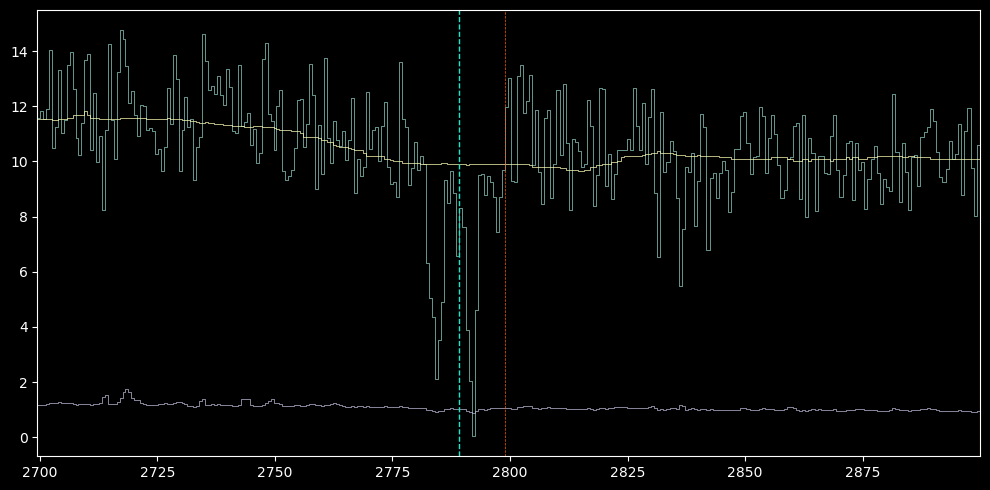

In [6]:
import importlib
importlib.reload(badass)
importlib.reload(badass_utils)

# Call the main function in BADASS
badass.run_BADASS(pathlib.Path(file),
#                   options_file = "BADASS_options",
#                   restart_file         = restart_file,
                  fit_options          = fit_options,
                  mcmc_options         = mcmc_options,
                  comp_options         = comp_options,
                  # New line options
                  narrow_options = narrow_options,
                  broad_options  = broad_options,
                  absorp_options = absorp_options,
                  #
                  user_lines           = user_lines, # User-lines
                  user_constraints     = user_constraints, # User-constraints
                  user_mask            = user_mask, # User-mask
                  combined_lines       = combined_lines,
                  losvd_options        = losvd_options,
                  host_options         = host_options,
                  power_options        = power_options,
                  poly_options         = poly_options,
                  opt_feii_options     = opt_feii_options,
                  uv_iron_options      = uv_iron_options,
                  balmer_options       = balmer_options,
                  plot_options         = plot_options,
                  output_options       = output_options,
                 )
    #